# Anomalies in Time Series Data

**Lesson Goals**

- Use entropy as a quick way to identify fields that may have anomalies. 

- Use statistical properties to flag the data points that deviate from the expected. 

**The Data**

- Logs of API requests to our data containing sales information about our stores and items. 

- Type of target variable: **Continuous** or Discrete

- Type of observations: **Time Series** or Point in Time   


**The Questions**

- Are there unusual IP addresses accessing our data via the API? 

- Have we seen any spikes or unusual patterns in the size of requests? 

- In general: Does this new value deviate from what we would expect based on historical data? If so, is it something to be concerned about? Remember, we aren't detecting anomalies for the sake of detecting anomalies. 


_____________________________


## Wrangle Data

**Prepare Environment**

In [44]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()


**Acquire**

After doing some research, some experimentation of performing actions and watching the logs, we discovered what each of the fields represent. We then parse and name the fields accordingly. 

In [45]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df = pd.read_csv('https://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

For this research, we are only interested in the IP address, timestamp and size of the requests. 

In [46]:
df = df[['ip', 'timestamp', 'size']]

**Explore IP Address**

In this sample data, it's pretty easy to take a look at value counts to see those IP's that are rare. However, usually the data is much, much larger and looking at simple value counts is not going to be enough. 

In [47]:
# value counts

In [48]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

**Prepare Data to Explore Size**

First, we will resample the existing data to 30 minute increments. 

In [49]:
# select timestam
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))
df = df.set_index('timestamp')
df = df[['size']].resample('30T').max()

In [50]:
df = df.fillna(value=0)
df.head()

,size
timestamp,
2019-04-16 19:30:00+00:00,513736.0
2019-04-16 20:00:00+00:00,513736.0
2019-04-16 20:30:00+00:00,513736.0
2019-04-16 21:00:00+00:00,513736.0
2019-04-16 21:30:00+00:00,513736.0


**Aside: Simulate some new data to manufacture some anomalies**

Now, let's create a new dataframe that extends our data another year or so. 

In [51]:
new = pd.DataFrame([["[17/Apr/2019:13:00:00+0000]", 0],
                    ["[15/Mar/2020:00:00:00+0000]", 0]], columns=['timestamp','size'])

We will then resample 

In [52]:
new.timestamp = new.timestamp.str.replace(r'(\[|\])', '', regex=True)
new.timestamp = pd.to_datetime(new.timestamp.str.replace(':', ' ', 1))
new = new.set_index('timestamp')
new = new.resample('30T').max()

In [53]:
new = new.fillna(value=0)
new.head()

,size
timestamp,
2019-04-17 13:00:00+00:00,0.0
2019-04-17 13:30:00+00:00,0.0
2019-04-17 14:00:00+00:00,0.0
2019-04-17 14:30:00+00:00,0.0
2019-04-17 15:00:00+00:00,0.0


In [54]:
# get mean and standard deviation for randomly generating some data. 
mean = df['size'].mean()
std = df['size'].std()

Fill values with random number between `[0, mean+2*standard deviation]`. 

In [55]:
# new['size'] = new['size'].apply(lambda x: max(np.rint(np.random.normal(mean, std)), 0) if x==0 else x)
new['size'] = new['size'].apply(lambda x: np.random.randint(0, mean+2*std) if x==0 else x)

Fill with some anomalies by replacing the zeros that remain with random number between `[(mean+2*std), (mean+5*std)]`

In [56]:
new['size'] = new['size'].apply(lambda x: np.random.randint(mean+2*std, mean+5*std) if x<1000 else x)

Concatentate our new data with our original data

In [57]:
df = pd.concat([df, new])

(array([3.135e+03, 3.205e+03, 3.160e+03, 3.165e+03, 3.145e+03, 1.690e+02,
        2.000e+00, 3.000e+00, 2.000e+00, 8.000e+00]),
 array([      0. ,  151560.2,  303120.4,  454680.6,  606240.8,  757801. ,
         909361.2, 1060921.4, 1212481.6, 1364041.8, 1515602. ]),
 <a list of 10 Patch objects>)

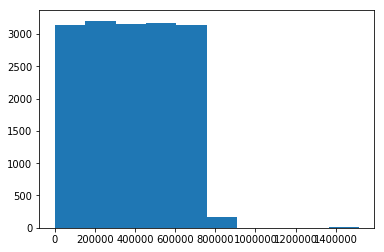

In [58]:
plt.hist(df['size'])

## Explore Size

First, let's represent size in MB for ease of conceptual understanding.  

In [59]:
df['size_mb'] = [n/1024/1024 for n in df['size']]
df = df[['size_mb']]

**Split into Train/Test**

In [60]:
train = df[:'2019-10-17']
validate = df['2019-10-18':'2020-01-15']
test = df['2020-01-16':]

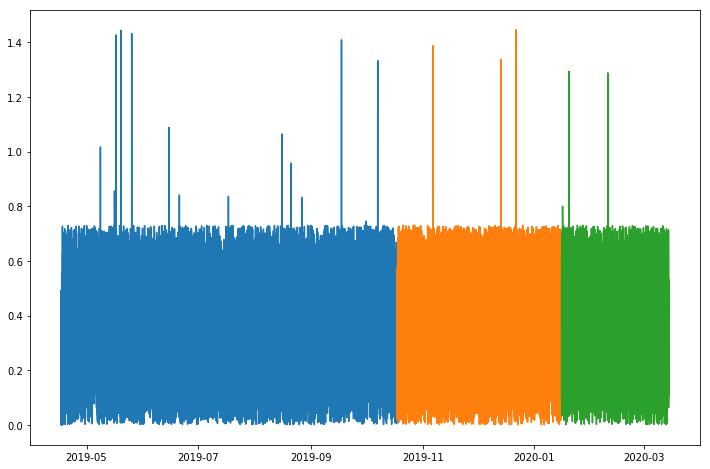

In [61]:
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(validate)
plt.plot(test)
plt.show()

## Simple Moving Average

In [62]:
# 1 week
sma = train.rolling(window=336).mean()

In [63]:
sma[333:339]

,size_mb
timestamp,
2019-04-23 18:00:00+00:00,NaN
2019-04-23 18:30:00+00:00,NaN
2019-04-23 19:00:00+00:00,0.322105
2019-04-23 19:30:00+00:00,0.321775
2019-04-23 20:00:00+00:00,0.320745
2019-04-23 20:30:00+00:00,0.320631


**Plot the SMA**

Text(0, 0.5, 'Size (MB)')

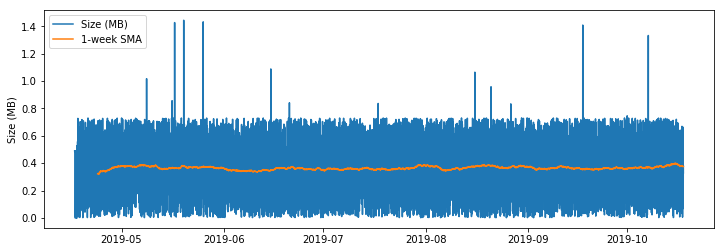

In [64]:

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, train, label='Size (MB)')

ax.plot(train.index, sma, label = '1-week SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

Try some other windows to compare. 

## Exponential Moving Average

SMA time series are much less noisy than the time series of the original data points. 
The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this: 

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where: 

- M = Number of time periods, span of the window

- $t_{0}$ = Latest value

- $t-1$ = Previous value

- $EMA_{t-1}$ = Exponential moving average of previous day. 

- The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. 
So we just need to define the following: 

- M = `span` argument = number of time periods. We will use 1 week, which is $24*2*7 = 336$

In [65]:
ema = train.ewm(span=336).mean()
ema.tail()

,size_mb
timestamp,
2019-10-17 21:30:00+00:00,0.366757
2019-10-17 22:00:00+00:00,0.368510
2019-10-17 22:30:00+00:00,0.367300
2019-10-17 23:00:00+00:00,0.367411
2019-10-17 23:30:00+00:00,0.367181


**Comparison of SMA and EMA**

Text(0, 0.5, 'Size (MB)')

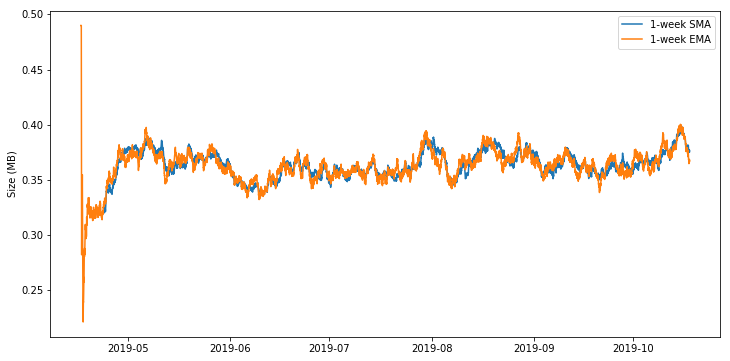

In [66]:
fig, ax = plt.subplots(figsize=(12,6))

# ax.plot(train.index, train, label='Size (MB)')

ax.plot(train.index, sma, label = '1-week SMA')
ax.plot(train.index, ema, label = '1-week EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)


## Bollinger Bands and %b

**Bollinger Bands**

- a volatility indicator and commonly used in stock market trading. 

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.  

**Midband**

- The Exponential Moving Average

- `midband = train.ewm(span=336).mean()`

**Upper & Lower Band**

- UB/LB = Midband +/- stdev * K

- `stdev = train.ewm(span=336).std()` 

- K = the number of standard deviations to go up and down from the EMA

**%b, Percent Bandwidth**

- Shows where the last value sits in relation to the bands

- $\%b = \frac{last-LB}{UB-LB}$ 

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband. 

**Bandwidth** 

- The width of the bands

- $Bandwidth = \frac{(UB-LB)}{Midband}$


In [67]:
# set the window span
span = 336

# compute midband
midband = train.ewm(span=span).mean()

# compute exponential stdev
stdev = train.ewm(span=span).std()

# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

Plot the bands

Text(0, 0.5, 'Size (MB)')

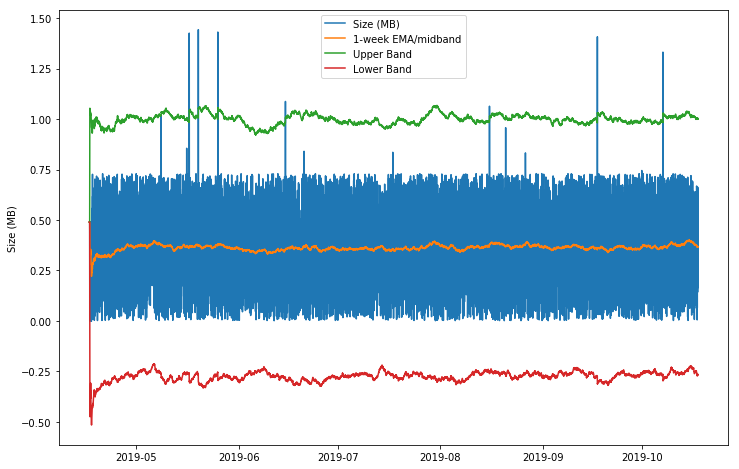

In [68]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(train.index, 
        midband, 
        label = '1-week EMA/midband')
ax.plot(train.index, 
        ub, 
        label = 'Upper Band')
ax.plot(train.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

Where do you think we will have a %b > 1? 

Compute %b

$\%b = \frac{last-LB}{UB-LB}$ 

In [ ]:
train = pd.concat([train, midband, ub, lb], axis=1)
train.columns = ['size_mb', 'midband', 'ub', 'lb']

In [75]:
train['pct_b'] = (train['size_mb'] - train['lb'])/(train['ub'] - train['lb'])

## Exercises

**file name:** time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Bonus:

Can you label students who are viewing both the web dev and data science curriculum?
Can you label students by the program they are in? 
Can you label users by student vs. staff?
What are Zach, Maggie, Faith, and Ryan's ids?

We are now going to fabricate some anomalous observations for demonstration purposes as we work through the lesson. 

In [ ]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)